# Bilateral texture filtering

El siguiente notebook es una implementación del paper: https://iranarze.ir/wp-content/uploads/2020/06/10840-English-IranArze.pdf

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('imagenes/fish1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

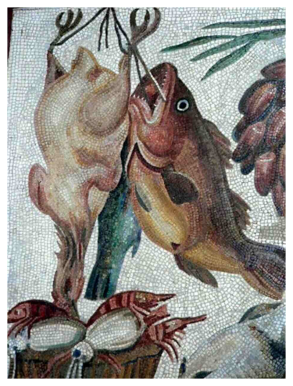

In [3]:
plt.figure(figsize = (5, 7))
plt.axis('off')
plt.imshow(img)
plt.show()

###  Modified Relative Total Variation (mRTV) 

In [4]:
# Calcula la Variacion Relativa Total modificada (mRTV) de cada pixel
# para una imagen en blanco y negro. (Eq. 3 y 4)
def get_mRTV(img, ksize):
    height, width = img.shape
    pad = ksize // 2

    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    grad_norm = np.sqrt(grad_x**2 + grad_y**2)

    mRTV = np.zeros(img.shape)

    for u in range(pad, height - pad):
        for v in range(pad, width - pad):
            window = (slice(u - pad, u + pad + 1), slice(v - pad, v + pad + 1))
            
            img_range = np.amax(img[window]) - np.amin(img[window])
            max_grad_norm = np.amax(grad_norm[window])
            sum_grad_norm = np.sum(grad_norm[window]) + 1e-9
            
            mRTV[u, v] = img_range * max_grad_norm / sum_grad_norm
    
    return mRTV

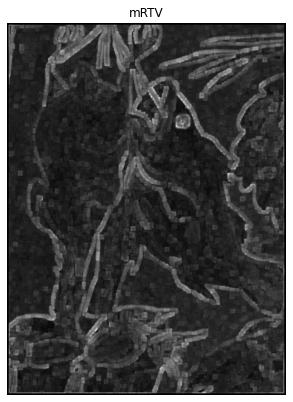

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
mRTV = get_mRTV(gray, 7)

plt.figure(figsize = (5, 7))
plt.title('mRTV')
plt.axis('off')
plt.imshow(mRTV, cmap = 'gray')
plt.show()

### Guidance image

In [6]:
# Calcula la imagen guía que se utilizará para el filtro bilateral. (Eq. 5 y 6)
def get_guidance_image(B, mRTV, ksize, sigma):
    height, width = B.shape
    pad = ksize // 2
    G = B.copy()
    alpha = np.zeros(B.shape)

    for u in range(pad, height - pad):
        for v in range(pad, width - pad):
            window = (slice(u - pad, u + pad + 1), slice(v - pad, v + pad + 1))
            i, j = np.unravel_index(np.argmin(mRTV[window]), (ksize, ksize))
            i, j = i + u - pad, j + v - pad

            G[u, v] = B[i, j]
            alpha[u, v] = 2/(1 + np.exp(-sigma*(mRTV[u, v] - mRTV[i, j]))) - 1

    return alpha*G + (1 - alpha)*B

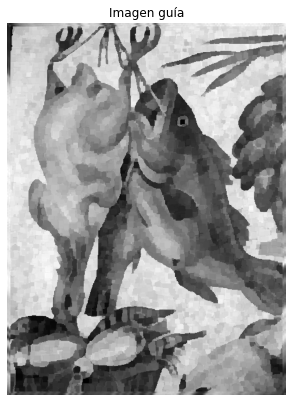

In [7]:
B = cv2.blur(gray, (7, 7))
G = get_guidance_image(B, mRTV, 7, 35)

plt.figure(figsize = (5, 7))
plt.title('Imagen guía')
plt.axis('off')
plt.imshow(G, cmap = 'gray')
plt.show()

### Bilateral filtering

In [8]:
#  Aplica un filtro bilateral con imagen guia sobre una imagen. (Eq. 2)
def bilateral_filtering(img, G, ksize, sigmaColor, sigmaSpace):
    height, width, channels = img.shape
    pad = ksize // 2
    img_out = img.copy()
    
    fkernel = np.empty((ksize, ksize))
    for u in range(ksize):
        for v in range(ksize):
            fkernel[u, v] = np.exp(-((u - pad)**2 + (v - pad)**2) / sigmaColor)

    for u in range(pad, height - pad):
        for v in range(pad, width - pad):
            window = (slice(u - pad, u + pad + 1), slice(v - pad, v + pad + 1))
            gkernel = np.exp(-(G[window] - G[u, v])**2 / sigmaSpace)
            kernel = fkernel * gkernel
            kernel /= np.sum(kernel)
            
            for c in range(channels):    
                img_out[u, v, c] = np.sum(kernel * img[window + (c,)])

    return img_out

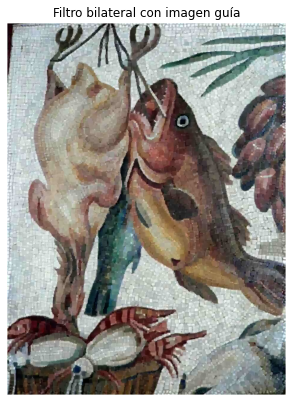

In [9]:
img_out = bilateral_filtering(img, G, 15, 8, 0.086)
    
plt.figure(figsize = (5, 7))
plt.title('Filtro bilateral con imagen guía')
plt.axis('off')
plt.imshow(img_out)
plt.show()

### Bilateral texture filtering

In [10]:
# Aplica un filtrado bilateral de textura sobre una imagen.
# Utilizamos por defecto los valores mencionados en el articulo.
def bilateral_texture_filtering(
    img, ksize, ksizeSpace, 
    sigma = None, sigmaColor = None, sigmaSpace = None, 
    niter = 5
):
    sigma = 5*ksize if sigma is None else sigma
    sigmaColor = ksize - 1 if sigmaColor is None else sigmaColor
    sigmaSpace = 0.05*np.sqrt(3) if sigmaSpace is None else sigmaSpace

    height, width, _ = img.shape
    img_out = np.pad(img, [(ksize, ksize), (ksize, ksize), (0, 0)], 'reflect')
    
    for n in range(niter):
        gray = cv2.cvtColor(img_out, cv2.COLOR_RGB2GRAY)
        
        B = cv2.blur(gray, (ksize, ksize))
        mRTV = get_mRTV(gray, ksize)
        G = get_guidance_image(B, mRTV, ksize, sigma)

        img_out = bilateral_filtering(img_out, G, ksizeSpace, sigmaColor, sigmaSpace)
        
    img_out = img_out[ksize:height - ksize, ksize:width - ksize, :]

    return img_out

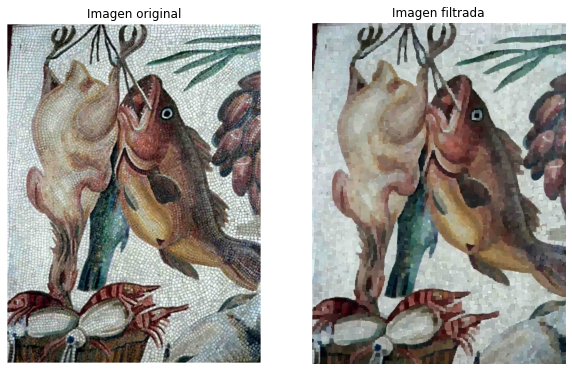

In [11]:
img_out = bilateral_texture_filtering(img, 7, 15)
    
plt.figure(figsize = (10, 7))
plt.subplot(121)
plt.title('Imagen original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Imagen filtrada')
plt.axis('off')
plt.imshow(img_out)
plt.show()

## Ejemplos

In [12]:
img = cv2.imread('imagenes/angel.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out = bilateral_texture_filtering(img, 9, 19)

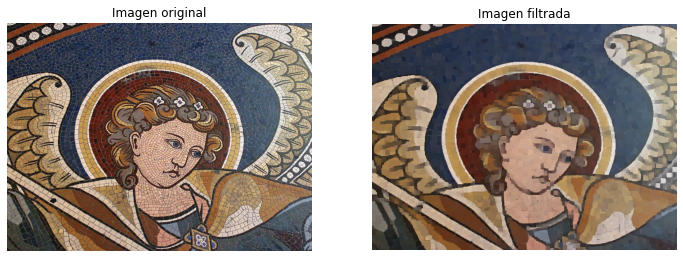

In [13]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.title('Imagen original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Imagen filtrada')
plt.axis('off')
plt.imshow(img_out)
plt.show()

In [14]:
img = cv2.imread('imagenes/fish2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out = bilateral_texture_filtering(img, 11, 21)

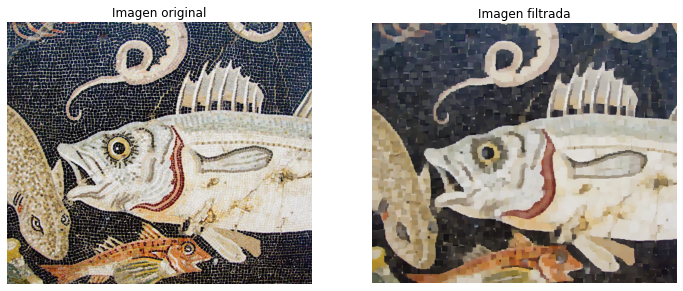

In [15]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.title('Imagen original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Imagen filtrada')
plt.axis('off')
plt.imshow(img_out)
plt.show()

In [16]:
img = cv2.imread('imagenes/imagine.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out = bilateral_texture_filtering(img, 15, 23)

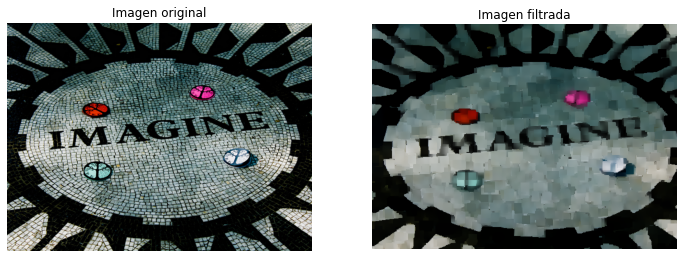

In [17]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.title('Imagen original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Imagen filtrada')
plt.axis('off')
plt.imshow(img_out)
plt.show()

In [18]:
img = cv2.imread('imagenes/mario.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out = bilateral_texture_filtering(img, 15, 21)

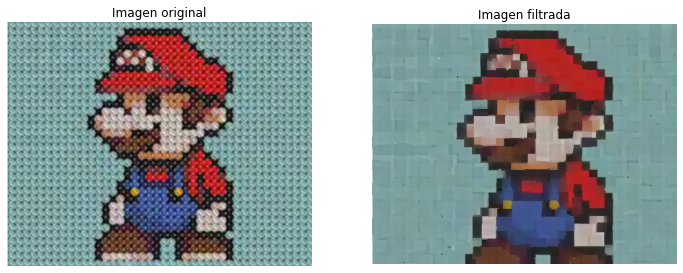

In [19]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.title('Imagen original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Imagen filtrada')
plt.axis('off')
plt.imshow(img_out)
plt.show()